<a href="https://colab.research.google.com/github/adalbertii/Modele-regresyjne/blob/main/employee-salary-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Employee Salaray Prediction**

In [1]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('Salary.csv')
#df.drop([''], axis=1, inplace=True)
display(df.head())

target = 'Salary'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Salary,Gender,Age,PhD
0,140.0,1,47,1
1,30.0,0,65,1
2,35.1,0,56,0
3,30.0,1,23,0
4,80.0,0,53,1



Inference: The Datset consists of 4 features & 100 samples.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Salary  100 non-null    float64
 1   Gender  100 non-null    int64  
 2   Age     100 non-null    int64  
 3   PhD     100 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 KB


In [4]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Gender     2
PhD        2
Age       43
Salary    73
dtype: int64

In [5]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 1 numerical & 2 categorical features.


In [6]:
#Checking the stats of all the columns

display(df.describe())

,Salary,Gender,Age,PhD
count,100.000000,100.000000,100.000000,100.000000
mean,52.524500,0.500000,46.880000,0.390000
std,42.220933,0.502519,15.271469,0.490207
min,0.250000,0.000000,20.000000,0.000000
25%,20.000000,0.000000,31.500000,0.000000
50%,39.300000,0.500000,49.000000,0.000000
75%,75.500000,1.000000,60.000000,1.000000
max,190.000000,1.000000,77.000000,1.000000


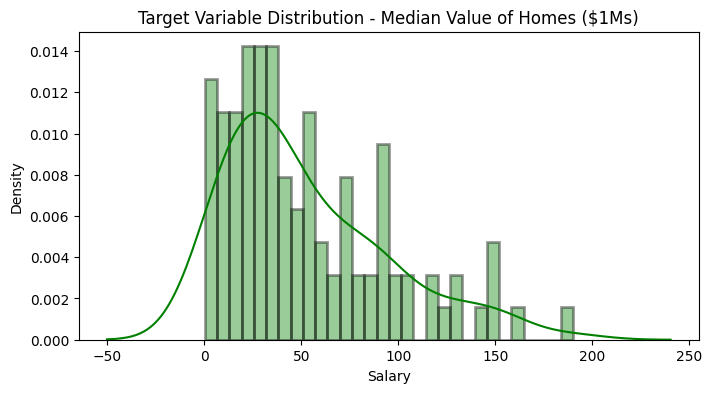

In [7]:
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()



Inference:The Target Variable seems to be be normally distributed, averaging around 20 units

In [9]:
cf

['Gender', 'PhD']

                               Visualising Categorical Features:                                


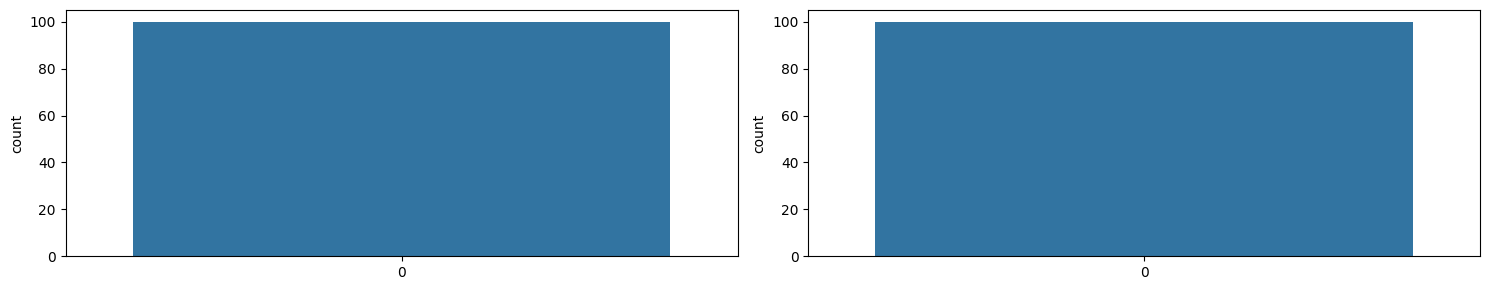

In [10]:
#Visualising the categorical features

print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(2,1,2)
        sns.countplot(df[cf[i]])

plt.tight_layout()
plt.show()

                                 Numeric Features Distribution                                  


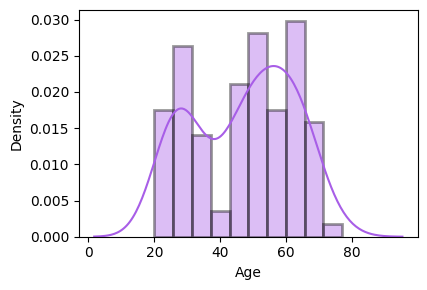

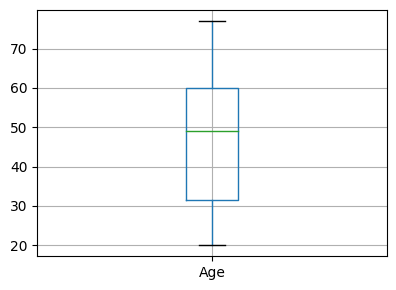

In [12]:
#Visualising the numeric features

print('\033[1mNumeric Features Distribution'.center(100))

n=4

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()



Inference: There seem to be some outliers. let us fix these in the upcoming section..

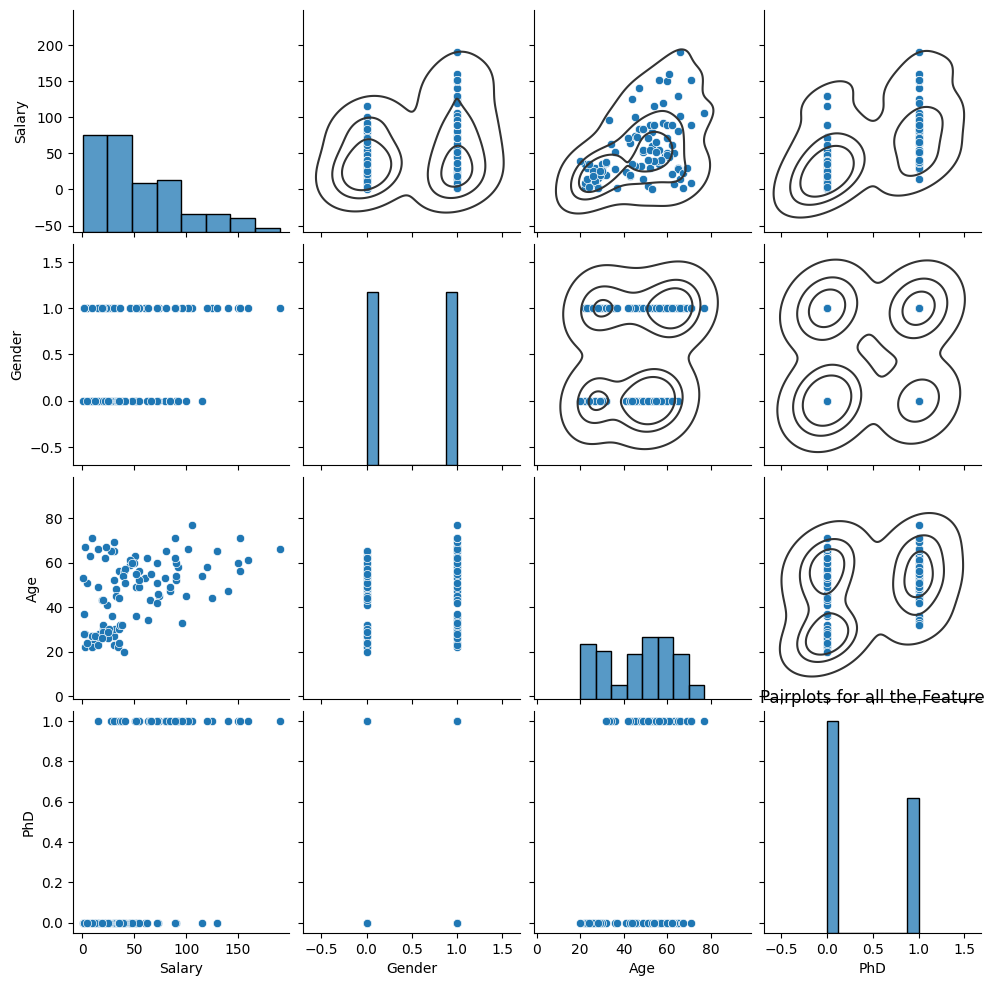

In [13]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

Data preprocessomg


In [14]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 1


In [15]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

        Total Null Values  Percentage
Salary                  0         0.0
Gender                  0         0.0
Age                     0         0.0
PhD                     0         0.0


In [16]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape

One-Hot Encoding on features:
Gender
PhD


(99, 4)

In [17]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Salary,Gender,Age,PhD
0,140.0,1,47,1
1,30.0,0,65,1
2,35.1,0,56,0
3,30.0,1,23,0
4,80.0,0,53,1



Inference:
Before removal of outliers, The dataset had 99 samples.
After removal of outliers, The dataset now has 99 samples.


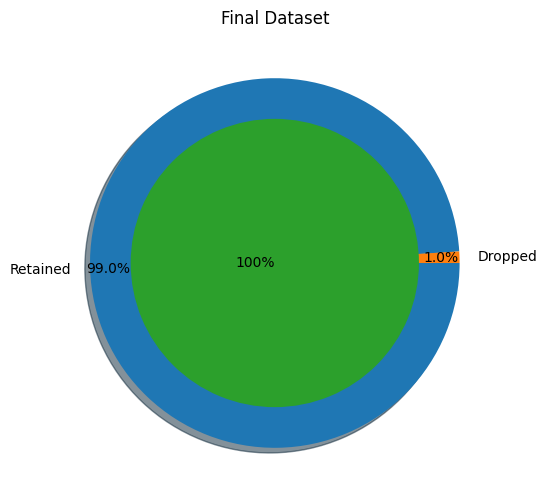


Inference: After the cleanup process, 1 samples were dropped, while retaining 1.0% of the data.


In [18]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

Data manipulation


In [20]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)




Original set  --->  (99, 3) (99,) 
Training set  --->  (79, 3) (79,) 
Testing set   --->  (20, 3)  (20,)


In [21]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Gender,Age,PhD
count,7.900000e+01,7.900000e+01,7.900000e+01
mean,-3.372829e-17,-7.149696e-17,-2.810691e-17
std,1.006390e+00,1.006390e+00,1.006390e+00
min,-9.627197e-01,-1.658134e+00,-8.469896e-01
25%,-9.627197e-01,-1.049611e+00,-8.469896e-01
50%,-9.627197e-01,1.994625e-01,-8.469896e-01
75%,1.038724e+00,9.040681e-01,1.180652e+00
max,1.038724e+00,1.993004e+00,1.180652e+00



                                          Standardardization on Testing set                                          


,Gender,Age,PhD
count,20.000000,20.000000,20.000000
mean,0.138074,0.257112,-0.238697
std,1.021572,0.837216,0.953321
min,-0.962720,-1.209748,-0.846990
25%,-0.962720,-0.328992,-0.846990
50%,1.038724,0.519738,-0.846990
75%,1.038724,0.856027,1.180652
max,1.038724,1.608674,1.180652


**Feature Selection/Extraction**

                                       Correlation Matrix                                       


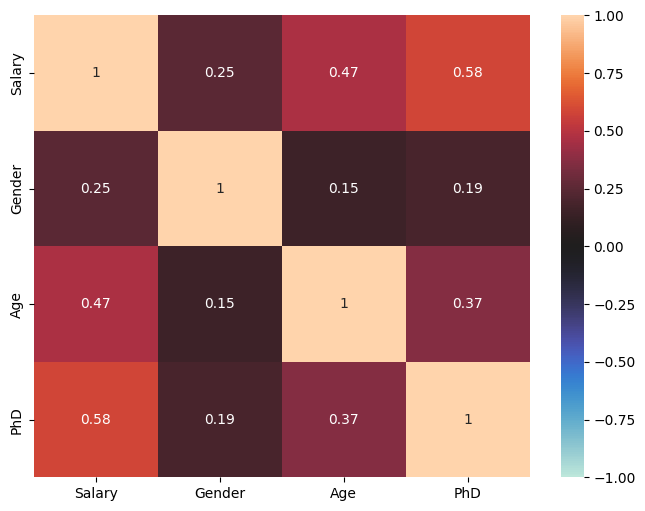

In [23]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[8,6])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

Inference: There seems to be strong multi-correlation between the features. Let us try to fix these...

In [24]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     19.56
Date:                Thu, 28 Sep 2023   Prob (F-statistic):           1.81e-09
Time:                        11:23:13   Log-Likelihood:                -386.86
No. Observations:                  79   AIC:                             781.7
Df Residuals:                      75   BIC:                             791.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     53.9139      3.741     14.413      0.000      46.462      61.366
Gender         6.0097      3.801      1.581      0.118      -1.563      13.583
Age           15.3796      4.250      3.618      0.001       6.912      23.847
PhD           16.0805      4.262      3.773      0.000       7.591      24.570
==============================================================================
Omnibus:                        2.880   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.237   Jarque-Bera (JB):                2.265
Skew:                           0.233   Prob(JB):                        0.322
Kurtosis:                       3.686   Cond. No.                         1.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



Approach: We can fix these multicollinearity with two techniques:

    Manual Method - Variance Inflation Factor (VIF)
    Automatic Method - Recursive Feature Elimination (RFE)
    Feature Elmination using PCA Decomposition



**Manual Method - VIF**

Dropped Features -->  ['PhD', 'Gender']


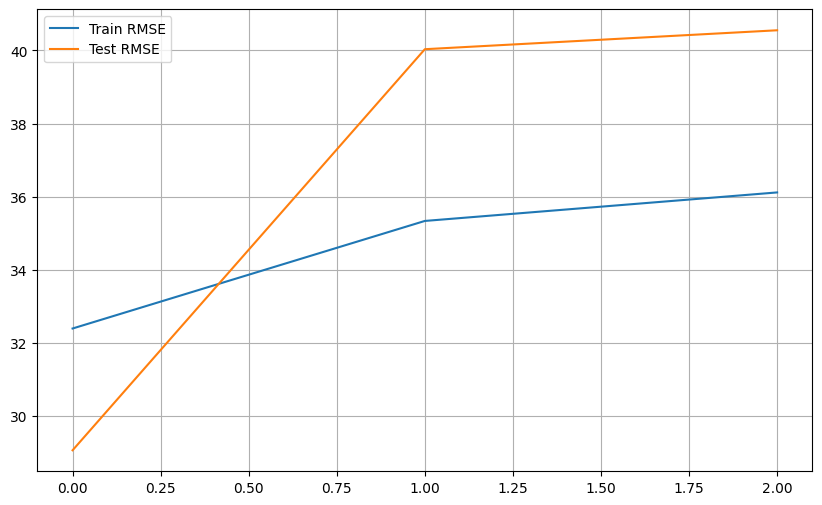

In [25]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
#Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
#Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

DROP=[];b=[]
LR = LinearRegression()
LR.fit(Train_X_std, Train_Y)

pred1 = LR.predict(Train_X_std)
pred2 = LR.predict(Test_X_std)

Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

for i in range(len(Train_X_std.columns)-1):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))

        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        #Trd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Train_Y, pred1)),2)
        #Tsd.loc[i,'ord-'+str(k)] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),2)

print('Dropped Features --> ',DROP)
#plt.plot(b)
#plt.show()
#print(API.summary())

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

**Automatic Method - RFE**

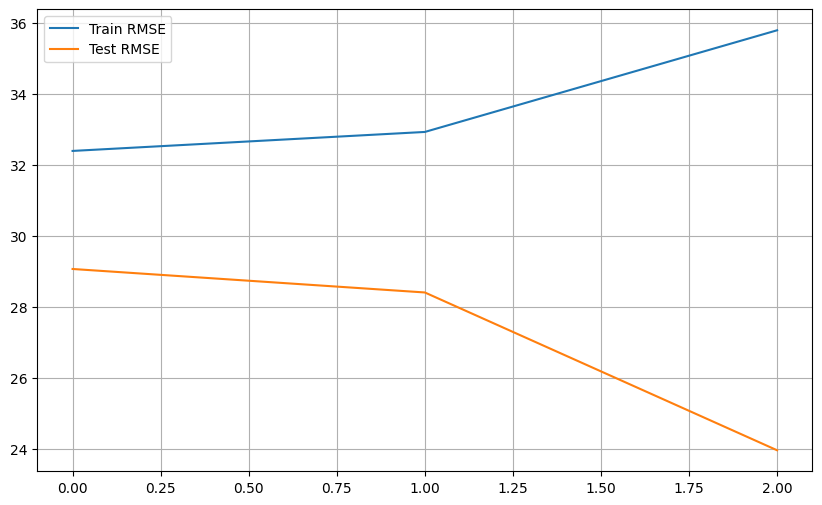

In [26]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-1
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

# plt.figure(figsize=[20,4])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

**Feature Elmination using PCA Decomposition**

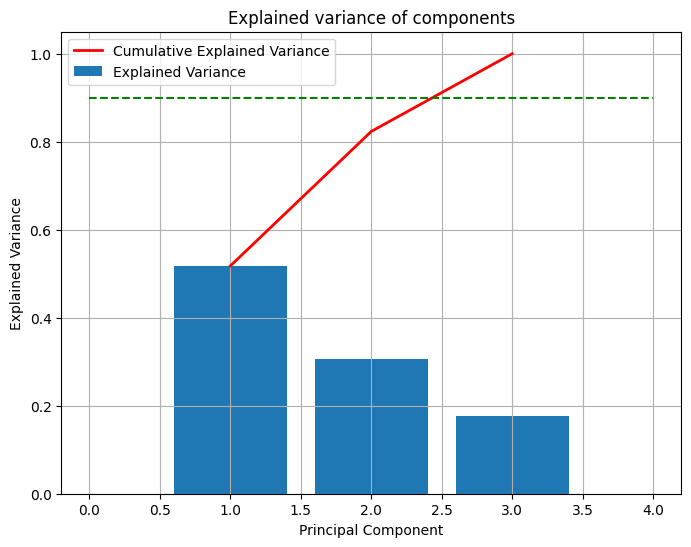

In [27]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

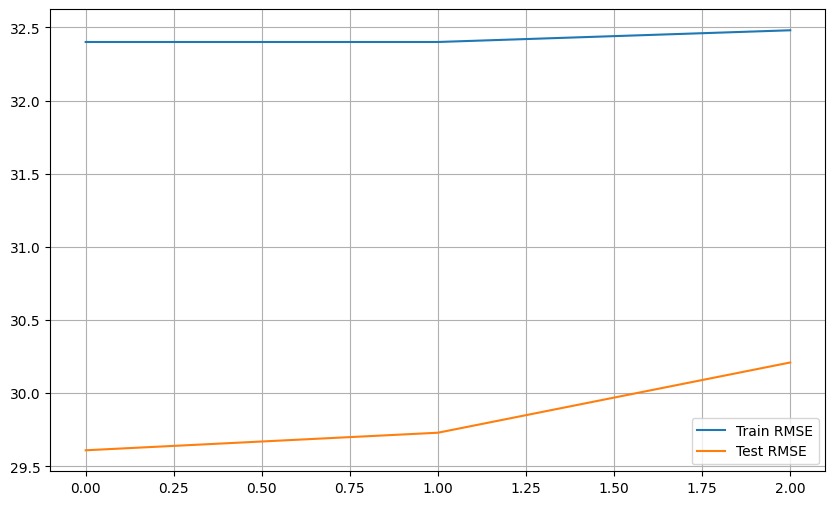

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)

    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

# plt.figure(figsize=[20,4.5])
# plt.subplot(1,3,1)
# sns.heatmap(Trd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max())
# plt.title('Train RMSE')
# plt.subplot(1,3,2)
# sns.heatmap(Tsd.loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+10)
# plt.title('Test RMSE')
# plt.subplot(1,3,3)
# sns.heatmap((Trd+Tsd).loc[:6], cmap='BuGn', annot=True, vmin=0, vmax=Trd.max().max()+25)
# plt.title('Total RMSE')
# plt.show()

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()


Inference:

It can be seen that the performance of the modelsis quiet comparable unpon dropping features using VIF, RFE & PCA Techniques. Comparing the RMSE plots, the optimal values were found for dropping most features using manual RFE Technique. But let us skip these for now, as the advanced ML Algorithms take care of multicollinearity.


**Predictive Modelling**

In [29]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=30].columns.values,1,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()




Objective:

Let us now try building multiple regression models & compare their evaluation metrics to choose the best fit model both training and testing sets...


<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.00966484 15.37959586 16.08049821]
The Intercept of the Regresion Model was found to be  53.91392405063291


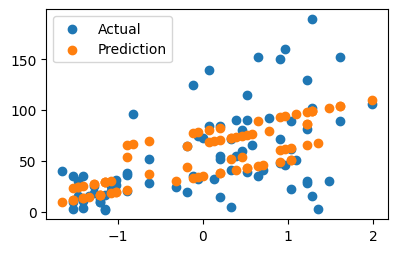



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4389762890726776
Residual Sum of Squares (RSS) on Training set  ---> 82906.39794704922
Mean Squared Error (MSE) on Training set       ---> 1049.448075279104
Root Mean Squared Error (RMSE) on Training set ---> 32.3951859892655

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.1874213681268623
Residual Sum of Squares (RSS) on Training set  ---> 16896.121689082363
Mean Squared Error (MSE) on Training set       ---> 844.806084454118
Root Mean Squared Error (RMSE) on Training set ---> 29.065548067327374

--------------------Residual Plots--------------------


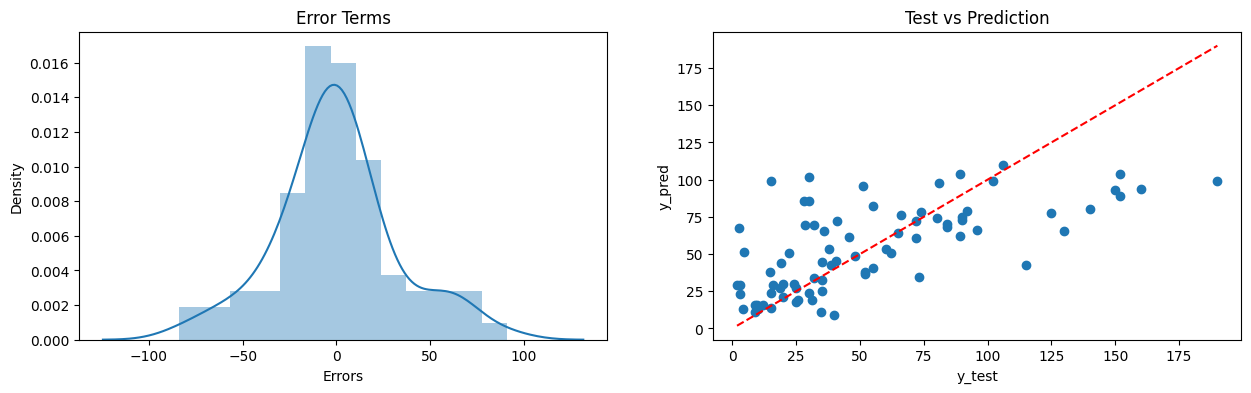

In [30]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

**Ridge Regression Model**

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.00966484 15.37959586 16.08049821]
The Intercept of the Regresion Model was found to be  53.91392405063291


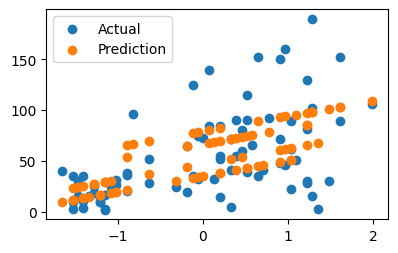



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.4389472255123041
Residual Sum of Squares (RSS) on Training set  ---> 82910.69287265603
Mean Squared Error (MSE) on Training set       ---> 1049.5024414260256
Root Mean Squared Error (RMSE) on Training set ---> 32.39602508682239

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.18838394459286167
Residual Sum of Squares (RSS) on Training set  ---> 16876.10663027251
Mean Squared Error (MSE) on Training set       ---> 843.8053315136254
Root Mean Squared Error (RMSE) on Training set ---> 29.04832751663382

--------------------Residual Plots--------------------


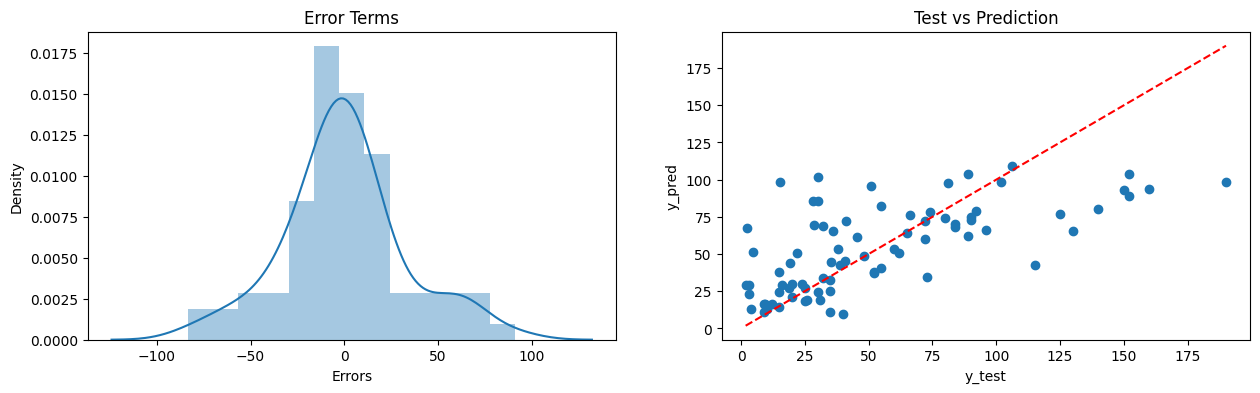

In [31]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

**Lasso Regression Model**

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.00966484 15.37959586 16.08049821]
The Intercept of the Regresion Model was found to be  53.91392405063291


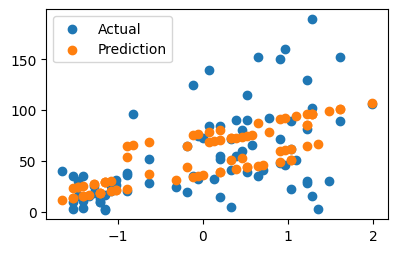



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.43790153073667926
Residual Sum of Squares (RSS) on Training set  ---> 83065.22250395414
Mean Squared Error (MSE) on Training set       ---> 1051.4585127082803
Root Mean Squared Error (RMSE) on Training set ---> 32.426201021832334

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.19977033472461792
Residual Sum of Squares (RSS) on Training set  ---> 16639.346979305516
Mean Squared Error (MSE) on Training set       ---> 831.9673489652757
Root Mean Squared Error (RMSE) on Training set ---> 28.843844212678647

--------------------Residual Plots--------------------


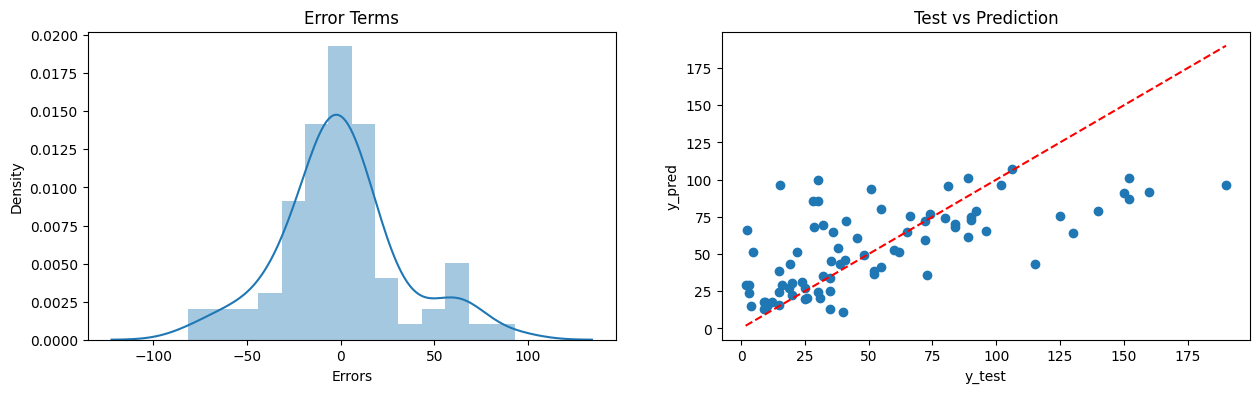

In [32]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

**Elastic-Net Regression**

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.00966484 15.37959586 16.08049821]
The Intercept of the Regresion Model was found to be  53.91392405063291


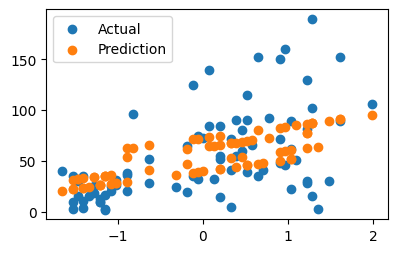



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.40892962437998787
Residual Sum of Squares (RSS) on Training set  ---> 87346.60375559906
Mean Squared Error (MSE) on Training set       ---> 1105.6532120961906
Root Mean Squared Error (RMSE) on Training set ---> 33.251364063692044

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.19490958400213443
Residual Sum of Squares (RSS) on Training set  ---> 16740.41761110155
Mean Squared Error (MSE) on Training set       ---> 837.0208805550776
Root Mean Squared Error (RMSE) on Training set ---> 28.931313149511162

--------------------Residual Plots--------------------


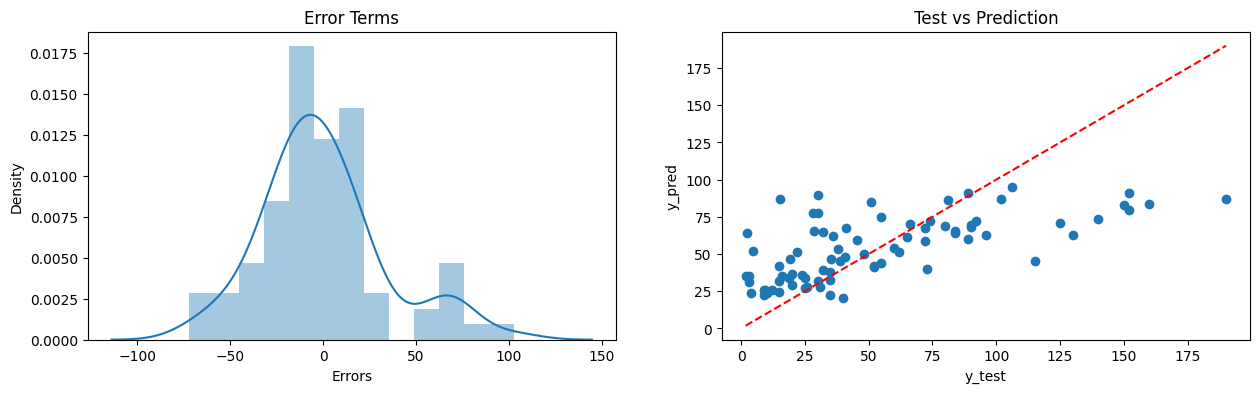

In [33]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

**Polynomial Regression Model**

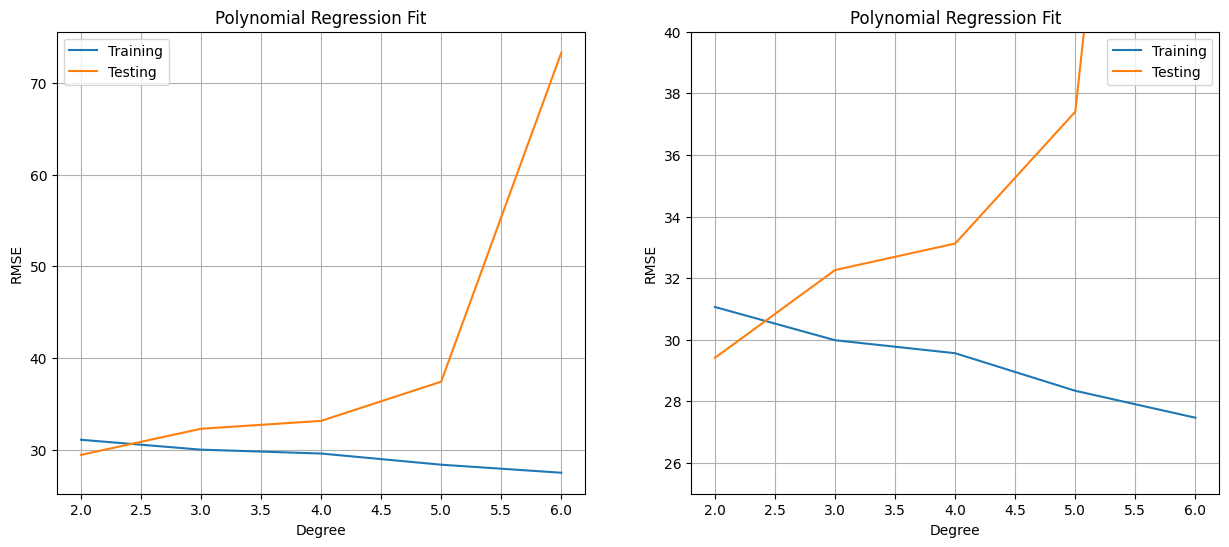

In [34]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=7

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)

    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))

    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([25,40])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

Inference: We can choose 2nd order polynomial regression as it gives the optimal training & testing scores...

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 6.00966484 15.37959586 16.08049821]
The Intercept of the Regresion Model was found to be  53.91392405063291


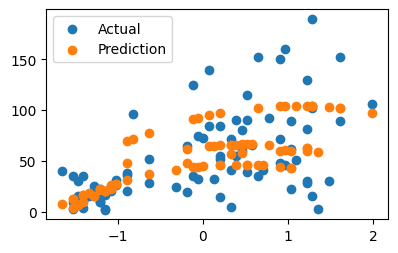



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.48420718533033125
Residual Sum of Squares (RSS) on Training set  ---> 76222.31203125
Mean Squared Error (MSE) on Training set       ---> 964.8393928006328
Root Mean Squared Error (RMSE) on Training set ---> 31.061863962110078

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.16783506416140637
Residual Sum of Squares (RSS) on Training set  ---> 17303.38390625
Mean Squared Error (MSE) on Training set       ---> 865.1691953125
Root Mean Squared Error (RMSE) on Training set ---> 29.413758605667862

--------------------Residual Plots--------------------


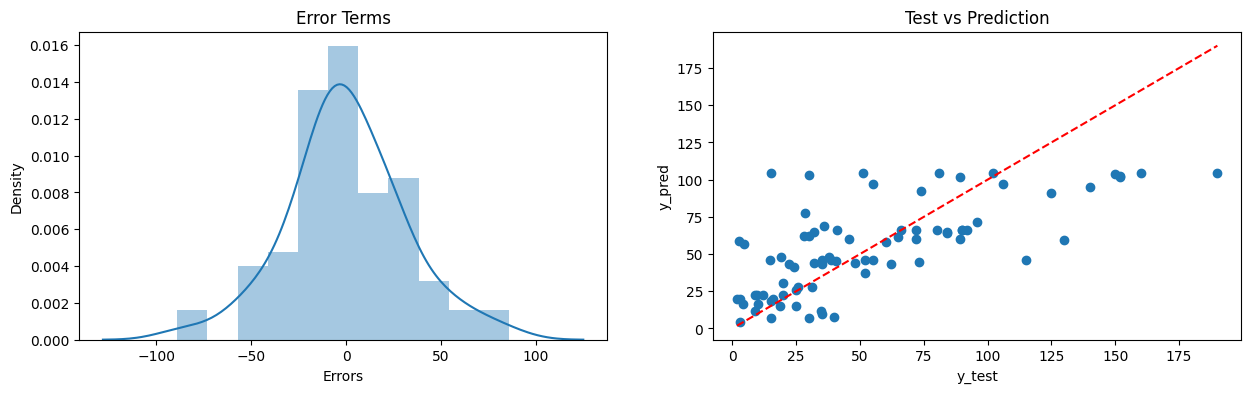

In [35]:
#Using the 2nd Order Polynomial Regression model (degree=3)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

**Comparing the Evaluation Metics of the Models**

In [36]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.438976,0.187421,82906.397947,16896.121689,1049.448075,844.806084,32.395186,29.065548
Ridge Linear Regression (RLR),0.438947,0.188384,82910.692873,16876.106630,1049.502441,843.805332,32.396025,29.048328
Lasso Linear Regression (LLR),0.437902,0.199770,83065.222504,16639.346979,1051.458513,831.967349,32.426201,28.843844
Elastic-Net Regression (ENR),0.408930,0.194910,87346.603756,16740.417611,1105.653212,837.020881,33.251364,28.931313
Polynomial Regression (PNR),0.484207,0.167835,76222.312031,17303.383906,964.839393,865.169195,31.061864,29.413759


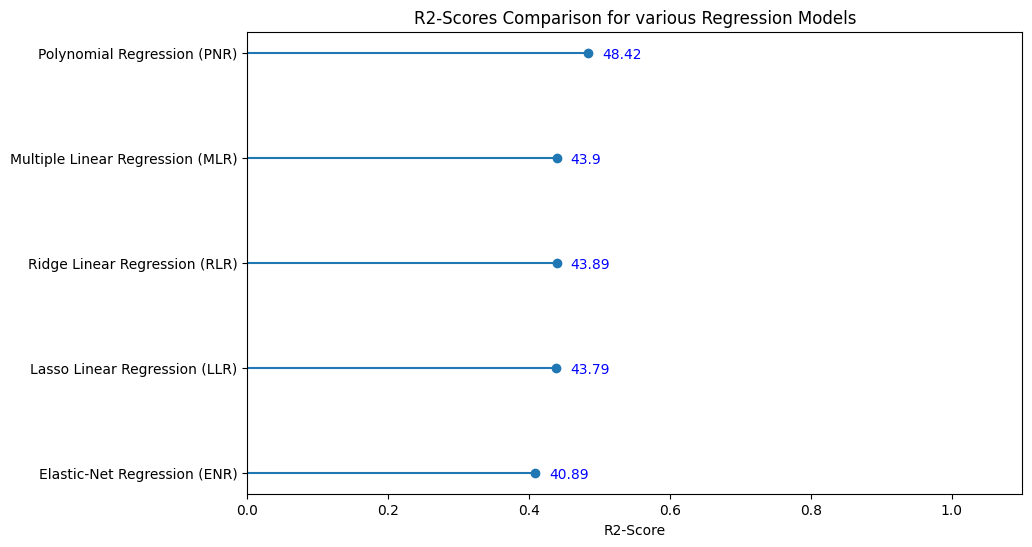

In [37]:
# R2-Scores Comparison for different Regression Models

R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
#plt.ylabel('Regression Models')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

Inference: From the above plot, it is clear that the polynomial regresion models have the highest explainability power to understand the dataset.

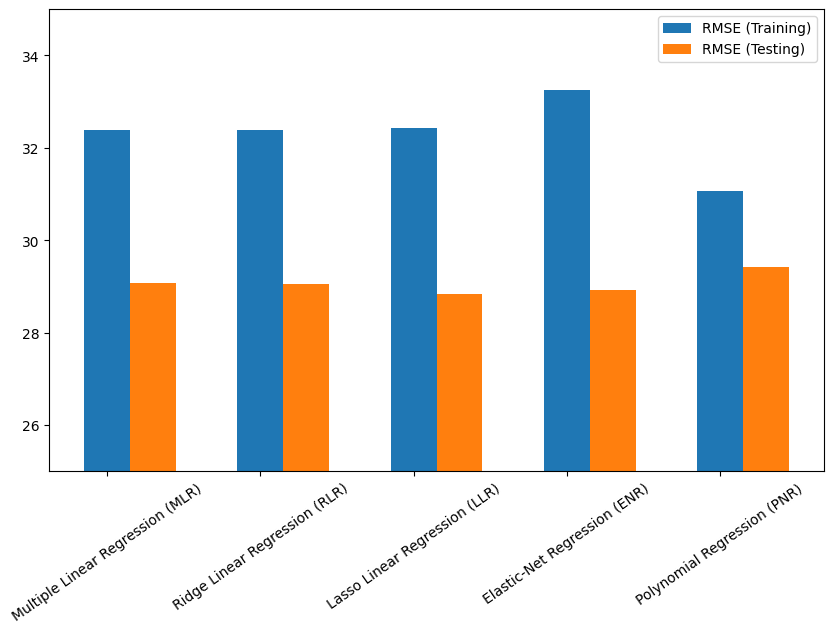

In [38]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5
#baxes = brokenaxes(ylims=((0,4),(524,532)))
#baxes.bar(np.arange(s), Model_Evaluation_Comparison_Matrix[cc[-2]].values, width=0.3, label='RMSE (Training)')
#baxes.bar(np.arange(s)+0.3, Model_Evaluation_Comparison_Matrix[cc[-1]].values, width=0.3, label='RMSE (Testing)')
# for index, value in enumerate(Model_Evaluation_Comparison_Matrix[cc[-2]].values):
#     plt.text(round(value,2), index, str(round(value,2)))
# for index, value in enumerate(Model_Evaluation_Comparison_Matrix[cc[-1]].values):
#     plt.text(round(value,2), index, str(round(value,2)))
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([25,35])
plt.show()



Inference:\ Lesser the RMSE, better the model! Also, provided the model should have close proximity with the training & testing scores. For this problem, it is can be said that polynomial regressions clearly is the best fit for the given dataset.


**Project Outcomes & Conclusions**


    The Dataset was quiet small with just 200 samples & after preprocessing 1% of the datasamples were dropped.
    Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.
    The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.
    Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
    While, Polynomial Regression (Order-2) was the best choise, yet it is safe to use multiple regression algorithm, as their scores were quiet comparable & also they're more generalisable.
